In [62]:
!pip install torchinfo

In [63]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("marjukibnabelayet/coffee-beans-saad")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/coffee-beans-saad


In [64]:
# Standard Libraries
import os
import time
import random
import glob
from datetime import datetime
from collections import OrderedDict
import platform
import psutil

# Data Handling and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Image Processing
import cv2
from PIL import Image, ImageOps

# Machine Learning and Deep Learning Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Torchvision for Datasets and Transforms
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop, ToPILImage
from torchvision.transforms.functional import gaussian_blur

# Scikit-learn for Metrics and Dataset Splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Utility Libraries
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from torchinfo import summary

In [65]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [66]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [67]:


base_dir = "/kaggle/input/coffee-beans-saad"

def create_dataframe(data_dir):
    file_paths = []
    labels = []
    
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # skip files, only consider folders
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            file_paths.append(image_path)
            labels.append(class_name)
    
    df = pd.DataFrame({"file_path": file_paths, "label": labels})
    df = df.sample(frac=1).reset_index(drop=True)  # shuffle
    return df

train_df = create_dataframe(os.path.join(base_dir, "train"))
test_df = create_dataframe(os.path.join(base_dir, "test"))

# Print few rows to confirm
print("Train:", train_df.head())
print("Test:", test_df.head())


Train:                                            file_path   label
0  /kaggle/input/coffee-beans-saad/train/Light/li...   Light
1  /kaggle/input/coffee-beans-saad/train/Light/li...   Light
2  /kaggle/input/coffee-beans-saad/train/Medium/m...  Medium
3  /kaggle/input/coffee-beans-saad/train/Dark/dar...    Dark
4  /kaggle/input/coffee-beans-saad/train/Medium/m...  Medium
Test:                                            file_path   label
0  /kaggle/input/coffee-beans-saad/test/Medium/me...  Medium
1  /kaggle/input/coffee-beans-saad/test/Light/lig...   Light
2  /kaggle/input/coffee-beans-saad/test/Medium/me...  Medium
3  /kaggle/input/coffee-beans-saad/test/Light/lig...   Light
4  /kaggle/input/coffee-beans-saad/test/Dark/dark...    Dark


In [68]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Map class names to integer labels
label_to_idx = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}

class CoffeeBeanDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['file_path']
        label_name = self.dataframe.iloc[idx]['label']
        label = label_to_idx[label_name]
        
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [69]:
train_dataset = CoffeeBeanDataset(train_df, transform=train_transforms)
test_dataset = CoffeeBeanDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [70]:
from collections import Counter

# Label distribution
train_label_counts = Counter(train_df["label"])
test_label_counts = Counter(test_df["label"])

print("Train Class Distribution:")
for k, v in train_label_counts.items():
    print(f"{k}: {v} images")

print("\nTest Class Distribution:")
for k, v in test_label_counts.items():
    print(f"{k}: {v} images")


Train Class Distribution:
Light: 300 images
Medium: 300 images
Dark: 300 images
Green: 300 images

Test Class Distribution:
Medium: 100 images
Light: 100 images
Dark: 100 images
Green: 100 images


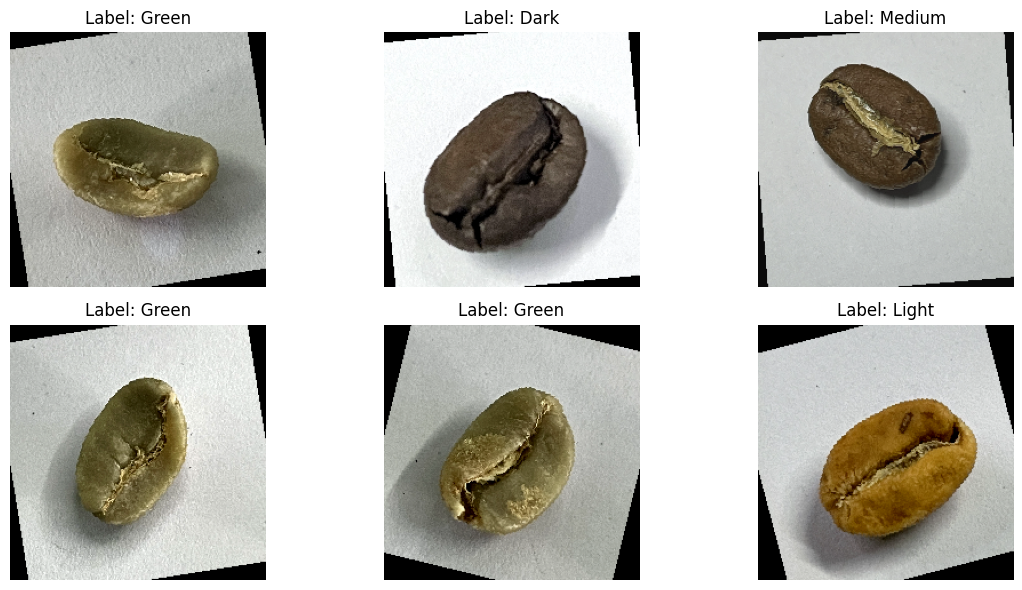

In [71]:


def show_sample_images(loader, class_map, num_images=6):
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()
        label = labels[i].item()
        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.title(f"Label: {list(class_map.keys())[list(class_map.values()).index(label)]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(train_loader, label_to_idx)


In [72]:

# Split only the training folder data
train_dataframe, valid_dataframe = train_test_split(
    train_df, test_size=0.18, stratify=train_df['label'], random_state=42
)

# Optional cleanup
train_dataframe = train_dataframe.reset_index(drop=True)
valid_dataframe = valid_dataframe.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print dataset sizes
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amount of data: ", len(train_df) + len(test_df))

# Print class distribution
def print_distribution(title, dataframe):
    counts = dataframe['label'].value_counts().sort_index()
    table_data = [[cls, cnt] for cls, cnt in counts.items()]
    print(f"\n{title}")
    print(tabulate(table_data, headers=["Class", "Count"], tablefmt="pretty"))

print_distribution("Train Dataset", train_dataframe)
print_distribution("Validation Dataset", valid_dataframe)
print_distribution("Test Dataset", test_df)


Training Data:  984
Validation Data:  216
Test Data:  400
-------------------------------------------
Total amount of data:  1600

Train Dataset
+--------+-------+
| Class  | Count |
+--------+-------+
|  Dark  |  246  |
| Green  |  246  |
| Light  |  246  |
| Medium |  246  |
+--------+-------+

Validation Dataset
+--------+-------+
| Class  | Count |
+--------+-------+
|  Dark  |  54   |
| Green  |  54   |
| Light  |  54   |
| Medium |  54   |
+--------+-------+

Test Dataset
+--------+-------+
| Class  | Count |
+--------+-------+
|  Dark  |  100  |
| Green  |  100  |
| Light  |  100  |
| Medium |  100  |
+--------+-------+


In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [74]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [75]:


class ImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        label_name = self.dataframe.iloc[index]['label']
        label = self.label_map[label_name]
        
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        return image, label


In [76]:


train_batch = 32
val_batch = 8

def data_transform():
    # Define train and validation/test transforms separately
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor()
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Create datasets (no more is_lb flag)
    train_dataset = ImageDataset(train_dataframe, transform=train_transform)
    valid_dataset = ImageDataset(valid_dataframe, transform=val_test_transform)
    test_dataset = ImageDataset(test_df, transform=val_test_transform)

    # Create dataloaders
    dataloader_train = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
    dataloader_valid = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)
    dataloader_test  = DataLoader(test_dataset, batch_size=val_batch, shuffle=False, num_workers=2)

    return dataloader_train, dataloader_valid, dataloader_test

# Call to load data
dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transform()


In [77]:


class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # output: 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # output: 32 x 112 x 112
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # output: 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # output: 64 x 56 x 56
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # output: 128 x 56 x 56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # output: 128 x 28 x 28
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # output: 256 x 28 x 28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # output: 256 x 14 x 14
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

# Usage example:
model = CustomCNN(num_classes=4).to(device)

# Optimizer and loss
import torch.optim as optim

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Print model summary (optional, requires torchinfo)
from torchinfo import summary
summary(model, input_size=(train_batch, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [32, 4]                   --
├─Sequential: 1-1                        [32, 256, 14, 14]         --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 224, 224]        64
│    └─ReLU: 2-3                         [32, 32, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 32, 112, 112]        --
│    └─Conv2d: 2-5                       [32, 64, 112, 112]        18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 112, 112]        128
│    └─ReLU: 2-7                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 64, 56, 56]          --
│    └─Conv2d: 2-9                       [32, 128, 56, 56]         73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 56, 56]         256
│    └─ReLU: 2-11                        [32, 128, 56, 56]         --
│   

In [78]:
# === Train ===
start_time = time.time()

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer,
    dataloader_train_dataset, dataloader_valid_dataset,
    num_epochs=10,  # <-- changed to 10 epochs
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
print(f"\n🕒 Total Training Time: {(end_time - start_time):.2f} seconds ({(end_time - start_time)/60:.2f} minutes)")

# === Save training logs to Excel ===
import pandas as pd
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_filename = f"/kaggle/working/training_data_{timestamp}.xlsx"

df = pd.DataFrame({
    "Epoch": list(range(1, len(train_loss_history) + 1)),
    "Train Loss": train_loss_history,
    "Train Accuracy": train_acc_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_acc_history
})

df.to_excel(excel_filename, index=False)
print(f"📊 Saved full training history to {excel_filename}")



========== Training Started ==========



Epoch 1/10: 100%|██████████| 31/31 [00:03<00:00, 10.00it/s, acc=0.583, loss=1.14]

[Epoch 1] Training Loss: 1.1438 | Accuracy: 0.5833


[Epoch 1] Validation Loss: 1.7851 | Accuracy: 0.3611
✅ Saved: /kaggle/working/best_model_epoch_1.pt | Best Accuracy: 0.3611
⏱️ Epoch time: 4.62 seconds



Epoch 2/10: 100%|██████████| 31/31 [00:03<00:00,  9.96it/s, acc=0.828, loss=0.429]

[Epoch 2] Training Loss: 0.4289 | Accuracy: 0.8283


[Epoch 2] Validation Loss: 0.5293 | Accuracy: 0.7639
✅ Saved: /kaggle/working/best_model_epoch_2.pt | Best Accuracy: 0.7639
⏱️ Epoch time: 4.63 seconds



Epoch 3/10: 100%|██████████| 31/31 [00:03<00:00, 10.20it/s, acc=0.896, loss=0.277]

[Epoch 3] Training Loss: 0.2769 | Accuracy: 0.8963


[Epoch 3] Validation Loss: 0.3016 | Accuracy: 0.8657
✅ Saved: /kaggle/working/best_model_epoch_3.pt | Best Accuracy: 0.8657
⏱️ Epoch time: 4.58 seconds



Epoch 4/10: 100%|██████████| 31/31 [00:03<00:00,  9.98it/s, acc=0.913, loss=0.225]

[Epoch 4] Training Loss: 0.2255 | Accuracy: 0.9126


[Epoch 4] Validation Loss: 0.2015 | Accuracy: 0.8981
✅ Saved: /kaggle/working/best_model_epoch_4.pt | Best Accuracy: 0.8981
⏱️ Epoch time: 4.63 seconds



Epoch 5/10: 100%|██████████| 31/31 [00:02<00:00, 10.54it/s, acc=0.94, loss=0.162] 

[Epoch 5] Training Loss: 0.1625 | Accuracy: 0.9400


[Epoch 5] Validation Loss: 0.0838 | Accuracy: 0.9722
✅ Saved: /kaggle/working/best_model_epoch_5.pt | Best Accuracy: 0.9722
⏱️ Epoch time: 4.48 seconds



Epoch 6/10: 100%|██████████| 31/31 [00:03<00:00, 10.30it/s, acc=0.943, loss=0.137]

[Epoch 6] Training Loss: 0.1369 | Accuracy: 0.9431


[Epoch 6] Validation Loss: 0.0521 | Accuracy: 0.9815
✅ Saved: /kaggle/working/best_model_epoch_6.pt | Best Accuracy: 0.9815
⏱️ Epoch time: 4.53 seconds



Epoch 7/10: 100%|██████████| 31/31 [00:03<00:00,  9.55it/s, acc=0.942, loss=0.217]

[Epoch 7] Training Loss: 0.2166 | Accuracy: 0.9421


[Epoch 7] Validation Loss: 0.0959 | Accuracy: 0.9630
⏱️ Epoch time: 3.83 seconds



Epoch 8/10: 100%|██████████| 31/31 [00:02<00:00, 10.39it/s, acc=0.941, loss=0.174]

[Epoch 8] Training Loss: 0.1739 | Accuracy: 0.9411


[Epoch 8] Validation Loss: 0.0607 | Accuracy: 0.9769
⏱️ Epoch time: 3.58 seconds



Epoch 9/10: 100%|██████████| 31/31 [00:02<00:00, 10.40it/s, acc=0.965, loss=0.116] 

[Epoch 9] Training Loss: 0.1158 | Accuracy: 0.9654


[Epoch 9] Validation Loss: 0.0516 | Accuracy: 0.9861
✅ Saved: /kaggle/working/best_model_epoch_9.pt | Best Accuracy: 0.9861
⏱️ Epoch time: 4.22 seconds



Epoch 10/10: 100%|██████████| 31/31 [00:03<00:00, 10.03it/s, acc=0.962, loss=0.116]

[Epoch 10] Training Loss: 0.1161 | Accuracy: 0.9624


[Epoch 10] Validation Loss: 0.0776 | Accuracy: 0.9815
⏱️ Epoch time: 3.64 seconds


✅ Training Complete ✅

🕒 Total Training Time: 42.75 seconds (0.71 minutes)
📊 Saved full training history to /kaggle/working/training_data_20250813_181845.xlsx


In [79]:
# Grad-CAM Setup and Visualization

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax().item()

        self.model.zero_grad()
        loss = output[0, target_class]
        loss.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]  # [C, H, W]

        for i in range(activations.shape[0]):
            activations[i] *= pooled_gradients[i]

        heatmap = torch.sum(activations, dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)

        return heatmap.numpy()

def show_gradcam_on_image(image_tensor, heatmap, alpha=0.4):
    # Convert tensor to numpy image [H, W, C] in range 0-1
    image = image_tensor.squeeze(0).cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = np.clip(image, 0, 1)

    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_colored = heatmap_colored[..., ::-1]  # Convert BGR to RGB

    # Superimpose heatmap onto image
    superimposed_img = heatmap_colored.astype(float) * alpha + (image * 255).astype(float)
    superimposed_img = superimposed_img / superimposed_img.max()
    superimposed_img = np.uint8(255 * superimposed_img)

    # Plot original and Grad-CAM
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Heatmap max: 1.0
Heatmap min: 0.0
Heatmap mean: 0.15438558


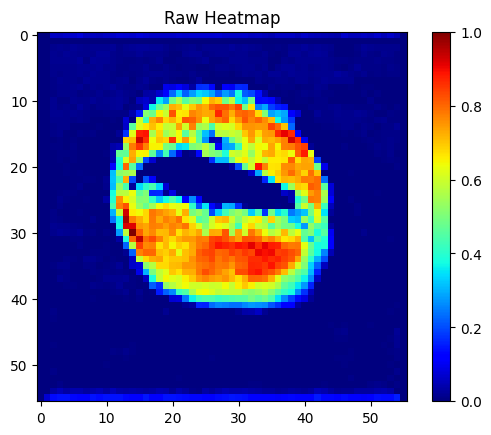

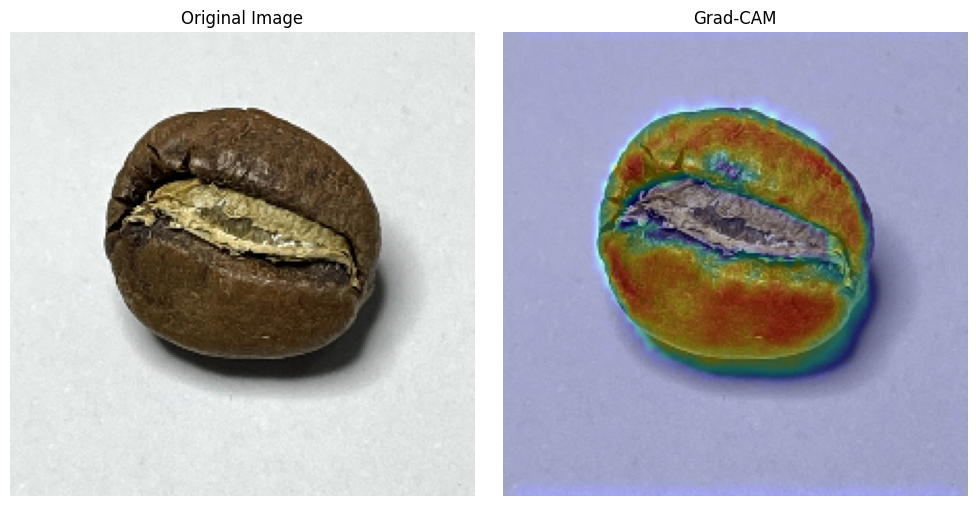

In [80]:
# === Run Grad-CAM on one test image ===



# Load the best checkpoint if available
best_model_path = sorted(glob.glob(os.path.join(save_path_checkpoints, "best_model_epoch_*.pt")))[-1]
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Get a sample from the test set
sample_img, sample_label = next(iter(dataloader_test_dataset))
sample_img = sample_img[0].unsqueeze(0).to(device)   # shape: [1, 3, 224, 224]
sample_label = sample_label[0].item()

# ✅ Select the last conv layer of your model
last_conv_layer = model.features[10]  # Correct: Conv2d(64, 128, ...)

# Initialize GradCAM
gradcam = GradCAM(model, target_layer=last_conv_layer)

# Generate heatmap (can use predicted class by omitting target_class)
heatmap = gradcam.generate(sample_img, target_class=sample_label)
print("Heatmap max:", np.max(heatmap))
print("Heatmap min:", np.min(heatmap))
print("Heatmap mean:", np.mean(heatmap))

plt.imshow(heatmap, cmap="jet")
plt.title("Raw Heatmap")
plt.colorbar()
plt.show()


# Show heatmap
show_gradcam_on_image(sample_img, heatmap)


Using latest Excel file: /kaggle/working/training_data_20250813_181845.xlsx
   Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy
0      1    1.143757        0.583333         1.785070             0.361111
1      2    0.428920        0.828252         0.529324             0.763889
2      3    0.276870        0.896341         0.301592             0.865741
3      4    0.225482        0.912602         0.201536             0.898148
4      5    0.162454        0.940041         0.083771             0.972222
   Epoch  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy
5      6    0.136929        0.943089         0.052079             0.981481
6      7    0.216644        0.942073         0.095883             0.962963
7      8    0.173936        0.941057         0.060740             0.976852
8      9    0.115833        0.965447         0.051621             0.986111
9     10    0.116136        0.962398         0.077636             0.981481
Total epochs logged: 10


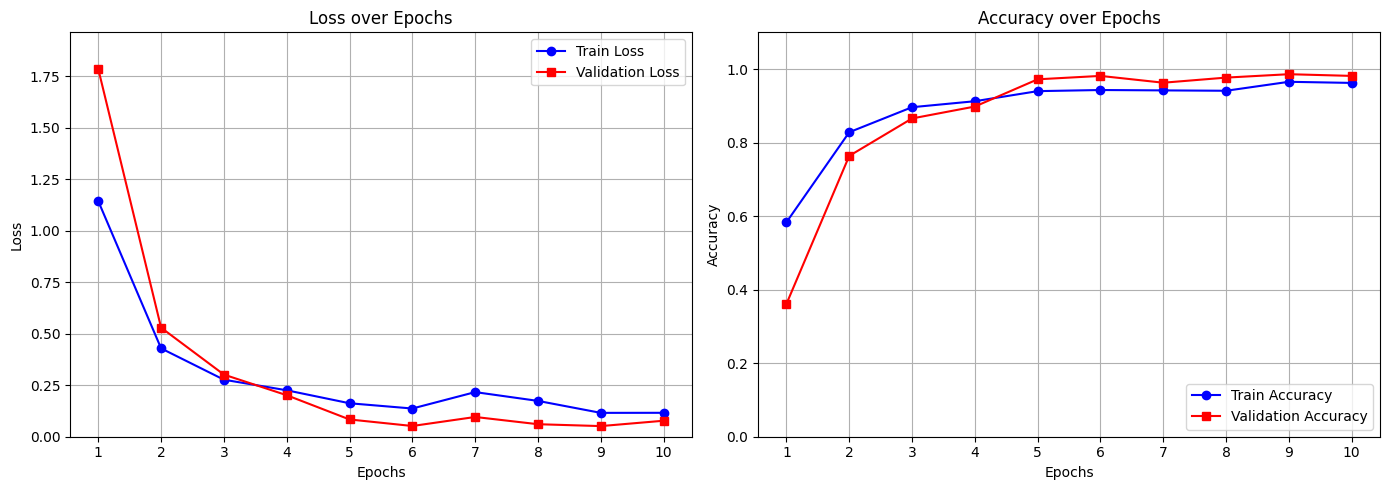

In [84]:


# --- Step 1: Automatically find the latest Excel file ---
folder = "/kaggle/working/"  # change this if your files are elsewhere
excel_files = glob.glob(os.path.join(folder, "*.xlsx"))

if len(excel_files) == 0:
    raise FileNotFoundError("No Excel files found in the folder!")

# Get the most recently modified Excel file
latest_excel_file = max(excel_files, key=os.path.getmtime)
print(f"Using latest Excel file: {latest_excel_file}")

# --- Step 2: Load the data ---
history = pd.read_excel(latest_excel_file)

# --- Step 3: Debug info ---
print(history.head())
print(history.tail())
print(f"Total epochs logged: {len(history)}")
print(f"Epochs recorded: {history['Epoch'].tolist()}")

# --- Step 4: Plotting ---
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], 'b-o', label='Train Loss')
plt.plot(history['Epoch'], history['Validation Loss'], 'r-s', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.ylim(0, max(history['Train Loss'].max(), history['Validation Loss'].max()) * 1.1)
plt.xticks(history['Epoch'][::max(1, len(history)//10)])  # reduce x-ticks if too many
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], 'b-o', label='Train Accuracy')
plt.plot(history['Epoch'], history['Validation Accuracy'], 'r-s', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')
plt.ylim(0, 1.1)
plt.xticks(history['Epoch'][::max(1, len(history)//10)])  # reduce x-ticks if too many
plt.grid(True)

plt.tight_layout()
plt.show()


In [82]:


def evaluate_model(model, dataloader_test, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    all_preds = []
    all_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader_test:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(dataloader_test.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return np.array(all_labels), np.array(all_preds)

# Use your test dataloader and device
y_true, y_pred = evaluate_model(model, dataloader_test_dataset, device)


Test Loss: 0.0538
Test Accuracy: 0.9800


In [ ]:
print(model.features)


<Figure size 800x600 with 0 Axes>

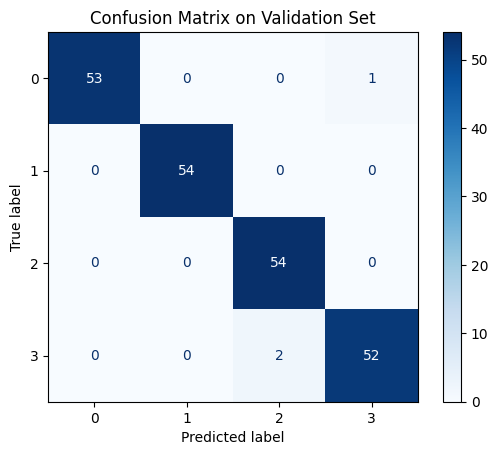

In [86]:


# === Confusion Matrix on Validation Set ===
model.eval()  # set model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloader_valid_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix on Validation Set")
plt.show()
